# NB: Evaluation of streamflow during future period

- xxx

In [1]:
%matplotlib inline

import os, sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import scale as mscale
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.lines import Line2D

from scripts.units import cms2csf
from scripts.utility import AutoVivification
from scripts.utility import PPFScale
mscale.register_scale(PPFScale)
import scripts.metrics as metrics

plt.rcParams.update({'figure.max_open_warning': 0})

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


## 1. Directories

In [2]:
main_path  = './'
ancillary_path = os.path.join(main_path, 'ancillary_data')
data_path = os.path.join(main_path, 'data')

## 2. Setups

In [6]:
scens = {
         'hist':   {'time':slice('1975-01-01', '2004-12-31'), 'period':['control']},
         'ssp245': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'ssp370': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'ssp585': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'rcp45':  {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'rcp85':  {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
        }

periods = {
         'control':  {'time':slice('1980-10-01', '2004-09-30'), 'lc':'xkcd:blue'},
         '2040s':    {'time':slice('2029-10-01', '2060-09-30'), 'lc':'xkcd:orange'},
         '2080s':    {'time':slice('2069-10-01', '2099-09-30'), 'lc':'xkcd:magenta'},
          }

models = {'summa': {'dire':'summa_mizuRoute'},
          'hms': {'dire':'hec_hms'},
         }

In [41]:
sim_cases = {
    'summa_CanESM5_hist': {'time_step':'daily', 'c':'xkcd:blue'}, 
    'hms_CanESM5_hist':      {'time_step':'daily', 'c':'xkcd:red'}, 
    'hms_CanESM5_ssp370':      {'time_step':'daily', 'c':'xkcd:red'}, 
    'summa_CanESM5_ssp370': {'time_step':'daily', 'c':'xkcd:blue'},
}

sim_ids = list(sim_cases.keys())

analysis_period = slice('1980-10-01', '2099-09-30')
start_date=analysis_period.start
end_date  =analysis_period.stop

#plot_sites = pd.read_csv(os.path.join(ancillary_path, 'site_headwater_list'), delim_whitespace=True, index_col=None, header=None)[0].values.tolist()
plot_sites = ['LIB']

flow_unit = 'cfs'

In [42]:
cms2cfs=35.3147

In [43]:
# redo sim_cases dictionary to populate more
for key, meta in sim_cases.items():
    model = key.split('_')[0]
    gcm   = key.split('_')[1]
    scen  = key.split('_')[2]
    sim_cases[key]['dire'] = models[model]['dire']
    sim_cases[key]['model'] = model
    sim_cases[key]['gcm'] = gcm 
    sim_cases[key]['scen'] = scen
    if model=='summa':
        sim_cases[key]['file_head'] = f'icar_{gcm}_{scen}'
    elif model == 'hms':
        if scen=='hist':
            scen1='Hist'
        else:
            scen1='F%s'%scen[3:]
        sim_cases[key]['file_head'] = f'{scen1}_icar_{gcm}_FormatDatTime'

In [44]:
sim_cases[key]

{'time_step': 'daily',
 'c': 'xkcd:blue',
 'dire': 'summa_mizuRoute',
 'model': 'summa',
 'gcm': 'CanESM5',
 'scen': 'ssp370',
 'file_head': 'icar_CanESM5_ssp370'}

## 3. Read ancillary data, e.g.,  flow sites geopackages, ascii

### Flow site name to be plotted

In [45]:
site_name = pd.read_csv(os.path.join(ancillary_path, 'meta_data.pnnl_sites.v3.txt'), sep='\s+')
if bool(plot_sites):
    site_name = site_name[site_name['label'].isin(plot_sites)] #
site_name

,reachID,hruId,label
28,78013865,170101011208,LIB


----
## 4. Read simulated flow time series

https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [46]:
%%time
print("---- Read validation period simulated flow ----")
ds_sim = {}

for case, meta in sim_cases.items():
    # SUMMA reading
    if meta["model"] == "summa":
        sim_flow = os.path.join(data_path, meta["dire"], "%s.nc" % (meta["file_head"]))
        ds_tmp = xr.open_dataset(sim_flow).sel(time=analysis_period).compute()
        ds_sim[case] = ds_tmp.assign_coords(site=ds_tmp["site"].values).drop_vars(
            ["reachID"]
        )
        ds_sim[case]["streamflow"] = ds_sim[case]["streamflow"].rename({"seg": "site"})
        if meta["time_step"] != "daily":
            ds_sim[case] = ds_sim[case].resample(time="1D").mean()

    # HMS reading
    elif meta["model"] == "hms":
        sim_flow = os.path.join(data_path, meta["dire"], "%s.csv" % (meta["file_head"]))
        df = pd.read_csv(sim_flow, index_col=[0], header=0, comment="#", thousands=",")
        df.rename(
            columns=lambda x: x.replace(" ", ""), inplace=True
        )  # remove tailing and heading spaces x.strip()
        for ix, row in df.iterrows():
            # Replace '24:00' with '00:00' of the next day
            if "24:00" in row["DateTime"]:
                row["DateTime"] = row["DateTime"].replace("24:00", "00:00")
                df.loc[ix, "DateTime"] = (
                    pd.to_datetime(row["DateTime"], format="%d %b %Y, %H:%M")
                    + pd.Timedelta(days=1)
                ).strftime("%d %b %Y, %H:%M")
        df["DateTime"] = pd.to_datetime(
            df["DateTime"], format="%d %b %Y, %H:%M", errors="coerce"
        )
        df.rename(columns={"DateTime": "time"}, inplace=True)
        df["site"] = "LIB"
        df.set_index(["time", "site"], inplace=True)
        for col in df.columns:
            col_meta = col.split("_")
            if len(col_meta)==5:
                case_mod = "hms_%s_ssp%s_%s" % (
                    col.split("_")[2],
                    col.split("_")[3],
                    col.split("_")[4],
                )  # redo column name
            elif len(col_meta)==4:
                case_mod = "hms_%s_hist_%s" % (
                    col.split("_")[2],
                    col.split("_")[3],
                )  # redo column name
            ds_sim[case_mod] = (
                df[col]
                .rename("streamflow")
                .astype("float32")
                .to_xarray()
                .sel(time=analysis_period)
                .to_dataset()
            )

            if meta["time_step"] != "daily":
                ds_sim[case_mod] = ds_sim[case_mod].resample(time="1D").mean()

    print("%s" % case)

---- Read validation period simulated flow ----
summa_CanESM5_hist
hms_CanESM5_hist
hms_CanESM5_ssp370
summa_CanESM5_ssp370
CPU times: user 17.2 s, sys: 51.5 ms, total: 17.3 s
Wall time: 18.2 s


### Reference flow

In [12]:
%%time
print('---- Read observed flow ----')
obs_tmp = []
for index, site in site_name.iterrows():
    obs_flow = os.path.join(data_path, f"obs/daily.cms.nc")
    ds_tmp = xr.open_dataset(obs_flow).sel(time=periods['control']['time'])
    ds_tmp['streamflow'] = ds_tmp['streamflow']*cms2cfs
    obs_tmp.append(ds_tmp)
ds_obs = xr.concat(obs_tmp,dim="site")

---- Read observed flow ----
CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 13.2 ms


## 5. Per-site analysis and plots

### 5.1 Compute flow metrics

- annual maximum and minimum flow and timing (flow metrics)

In [10]:
# Annual maximum 3-day flow  
ds_annual_max ={}
ds_annual_min ={}
ds_annual_centroid = {}
for case in ds_sim.keys():
    ds_annual_max[case] = metrics.annual_max(ds_sim[case]['streamflow'].rolling(time=7, center=True).mean().sel(time=analysis_period))
    ds_annual_min[case] = metrics.annual_min(ds_sim[case]['streamflow'].rolling(time=7, center=True).mean().sel(time=analysis_period))
    ds_annual_centroid[case] = metrics.annual_centroid(ds_sim[case]['streamflow'].sel(time=analysis_period))
    
ds_annual_max_obs = metrics.annual_max(ds_obs['streamflow'].rolling(time=7, center=True).mean().sel(time=analysis_period))
ds_annual_min_obs = metrics.annual_min(ds_obs['streamflow'].rolling(time=7, center=True).mean().sel(time=analysis_period))
ds_annual_centroid_obs = metrics.annual_centroid(ds_obs['streamflow'].sel(time=analysis_period))

## 5.2 Compute erro metrics - only for historical period

- skill metrics (comparison with reference flow data)

In [11]:
%%time

print('--- Compute daily performance metrics ---')
num_site = len(plot_sites)

flow_stats = AutoVivification()
for index, site in enumerate(plot_sites):

    obs = ds_obs.sel(site=site, time=analysis_period)['streamflow'].values
    tlen = len(obs)
    obs_prob=np.arange(1,float(tlen)+1)/(1+tlen)*100
    ix_fdc = np.where(obs_prob>90)[0]
    obs_fdc_high = np.sort(obs)[ix_fdc]
    qthresh90 = np.percentile(obs, 90)
    
    print(f"{index}-{site}")

    for ix_obj, case in enumerate(ds_sim.keys()):
        sim = ds_sim[case].sel(site=site, time=analysis_period)['streamflow'].values
        sim_fdc_high = np.sort(sim)[ix_fdc]

        flow_stats[site][f'{case}_KGE'] = metrics.kge(obs, sim)
        flow_stats[site][f'{case}_NSE'] = metrics.nse(obs, sim)
        flow_stats[site][f'{case}_q90bias'] = metrics.pbias(obs[obs>qthresh90], sim[obs>qthresh90])  
        flow_stats[site][f'{case}_fdc90bias'] = metrics.pbias(obs_fdc_high, sim_fdc_high)
        flow_stats[site][f'{case}_alpha'] = metrics.alpha(obs, sim)
        flow_stats[site][f'{case}_beta'] = metrics.beta(obs, sim)
        flow_stats[site][f'{case}_r'] = metrics.corr(obs, sim)
        
df_daily_flow_stats = pd.DataFrame.from_dict(flow_stats, orient='index')
df_daily_flow_stats.index.name = 'site'
df_daily_flow_stats.columns = df_daily_flow_stats.columns.str.rsplit('_', n=1, expand=True)
df_daily_flow_stats.columns = df_daily_flow_stats.columns.swaplevel(0, 1)
df_daily_flow_stats.sort_index(axis=1, level=0, inplace=True)

--- Compute daily performance metrics ---
0-LIB
CPU times: user 25 ms, sys: 0 ns, total: 25 ms
Wall time: 30.8 ms


In [12]:
%%time

print('--- Compute monthly performance metrics ---')
num_site = len(plot_sites)

flow_stats = AutoVivification()
for index, site in enumerate(plot_sites):

    obs = ds_obs.sel(site=site, time=analysis_period)['streamflow'].resample(time='1ME').mean(dim='time').values
    
    print(f"{index}-{site}")

    for ix_obj, case in enumerate(ds_sim.keys()):
        sim = ds_sim[case].sel(site=site, time=analysis_period)['streamflow'].resample(time='1ME').mean(dim='time').values

        #label = sim_cases[case]['label']
        flow_stats[site][f'{case}_KGE']   = metrics.kge(obs, sim)
        flow_stats[site][f'{case}_NSE']   = metrics.nse(obs, sim)
        flow_stats[site][f'{case}_alpha'] = metrics.alpha(obs, sim)
        flow_stats[site][f'{case}_beta']  = metrics.beta(obs, sim)
        flow_stats[site][f'{case}_corr']  = metrics.corr(obs, sim)
        
df_month_flow_stats = pd.DataFrame.from_dict(flow_stats, orient='index')
df_month_flow_stats.index.name = 'site'
df_month_flow_stats.columns = df_month_flow_stats.columns.str.rsplit('_', n=1, expand=True)
df_month_flow_stats.columns = df_month_flow_stats.columns.swaplevel(0, 1)
df_month_flow_stats.sort_index(axis=1, level=0, inplace=True)

--- Compute monthly performance metrics ---
0-LIB
CPU times: user 98.5 ms, sys: 3.95 ms, total: 102 ms
Wall time: 199 ms


In [13]:
with pd.option_context('display.float_format', '{:,.2f}'.format, 'display.max_columns', None):
    display(df_daily_flow_stats)

KGE                                          \
     hms_CanESM5_hist_M1 hms_CanESM5_hist_M2 hms_CanESM5_hist_M3   
site                                                               
LIB                 0.66                0.64                0.68   

                                                                  \
     hms_CanESM5_hist_M4 hms_CanESM5_hist_M5 hms_CanESM5_hist_M6   
site                                                               
LIB                 0.65                0.65                0.62   

                                                            NSE  \
     hms_CanESM5_hist_M7 summa_CanESM5_hist hms_CanESM5_hist_M1   
site                                                              
LIB                 0.63               0.67                0.33   

                                                                  \
     hms_CanESM5_hist_M2 hms_CanESM5_hist_M3 hms_CanESM5_hist_M4   
site                                                               
LIB                 0.28                0.37                0.33   

                                                                  \
     hms_CanESM5_hist_M5 hms_CanESM5_hist_M6 hms_CanESM5_hist_M7   
site                                                               
LIB                 0.32                0.26                0.25   

                                      alpha                      \
     summa_CanESM5_hist hms_CanESM5_hist_M1 hms_CanESM5_hist_M2   
site                                                              
LIB                0.33                1.20                1.22   

                                                                  \
     hms_CanESM5_hist_M3 hms_CanESM5_hist_M4 hms_CanESM5_hist_M5   
site                                                               
LIB                 1.16                1.20                1.21   

                                                                 \
     hms_CanESM5_hist_M6 hms_CanESM5_hist_M7 summa_CanESM5_hist   
site                                                              
LIB                 1.25                1.22               1.10   

                    beta                                          \
     hms_CanESM5_hist_M1 hms_CanESM5_hist_M2 hms_CanESM5_hist_M3   
site                                                               
LIB                 0.98                0.98                0.97   

                                                                  \
     hms_CanESM5_hist_M4 hms_CanESM5_hist_M5 hms_CanESM5_hist_M6   
site                                                               
LIB                 0.95                0.97                0.96   

                                                      fdc90bias  \
     hms_CanESM5_hist_M7 summa_CanESM5_hist hms_CanESM5_hist_M1   
site                                                              
LIB                 0.99               0.97                0.10   

                                                                  \
     hms_CanESM5_hist_M2 hms_CanESM5_hist_M3 hms_CanESM5_hist_M4   
site                                                               
LIB                 0.14                0.09                0.10   

                                                                  \
     hms_CanESM5_hist_M5 hms_CanESM5_hist_M6 hms_CanESM5_hist_M7   
site                                                               
LIB                 0.10                0.14                0.15   

                                    q90bias                      \
     summa_CanESM5_hist hms_CanESM5_hist_M1 hms_CanESM5_hist_M2   
site                                                              
LIB                0.03               -0.16               -0.14   

                                                                  \
     hms_CanESM5_hist_M3 hms_CanESM5_hist_M4 hms_CanESM5_hist_M5   
site                                                               
LIB            

In [14]:
html = df_daily_flow_stats.to_html()
text_file = open("daily_flow_stat.html", "w")
text_file.write(html)
text_file.close()

In [15]:
with pd.option_context('display.float_format', '{:,.2f}'.format, 'display.max_columns', None):
    display(df_month_flow_stats)

KGE                                          \
     hms_CanESM5_hist_M1 hms_CanESM5_hist_M2 hms_CanESM5_hist_M3   
site                                                               
LIB                 0.68                0.67                0.69   

                                                                  \
     hms_CanESM5_hist_M4 hms_CanESM5_hist_M5 hms_CanESM5_hist_M6   
site                                                               
LIB                 0.68                0.67                0.63   

                                                            NSE  \
     hms_CanESM5_hist_M7 summa_CanESM5_hist hms_CanESM5_hist_M1   
site                                                              
LIB                 0.66               0.74                0.48   

                                                                  \
     hms_CanESM5_hist_M2 hms_CanESM5_hist_M3 hms_CanESM5_hist_M4   
site                                                               
LIB                 0.45                0.48                0.48   

                                                                  \
     hms_CanESM5_hist_M5 hms_CanESM5_hist_M6 hms_CanESM5_hist_M7   
site                                                               
LIB                 0.47                0.40                0.41   

                                      alpha                      \
     summa_CanESM5_hist hms_CanESM5_hist_M1 hms_CanESM5_hist_M2   
site                                                              
LIB                0.51                1.26                1.26   

                                                                  \
     hms_CanESM5_hist_M3 hms_CanESM5_hist_M4 hms_CanESM5_hist_M5   
site                                                               
LIB                 1.23                1.24                1.26   

                                                                 \
     hms_CanESM5_hist_M6 hms_CanESM5_hist_M7 summa_CanESM5_hist   
site                                                              
LIB                 1.30                1.26               1.13   

                    beta                                          \
     hms_CanESM5_hist_M1 hms_CanESM5_hist_M2 hms_CanESM5_hist_M3   
site                                                               
LIB                 0.98                0.98                0.97   

                                                                  \
     hms_CanESM5_hist_M4 hms_CanESM5_hist_M5 hms_CanESM5_hist_M6   
site                                                               
LIB                 0.95                0.96                0.96   

                                                           corr  \
     hms_CanESM5_hist_M7 summa_CanESM5_hist hms_CanESM5_hist_M1   
site                                                              
LIB                 0.99               0.97                0.81   

                                                                  \
     hms_CanESM5_hist_M2 hms_CanESM5_hist_M3 hms_CanESM5_hist_M4   
site                                                               
LIB                 0.80                0.80                0.79   

                                                                  \
     hms_CanESM5_hist_M5 hms_CanESM5_hist_M6 hms_CanESM5_hist_M7   
site                                                               
LIB                 0.80                0.79                0.79   

                         
     summa_CanESM5_hist  
site                     
LIB                0.78

In [16]:
html = df_month_flow_stats.to_html()
text_file = open("month_flow_stat.html", "w")
text_file.write(html)
text_file.close()

### 5.1 Flow reliability plots

Using matplotlib backend: inline


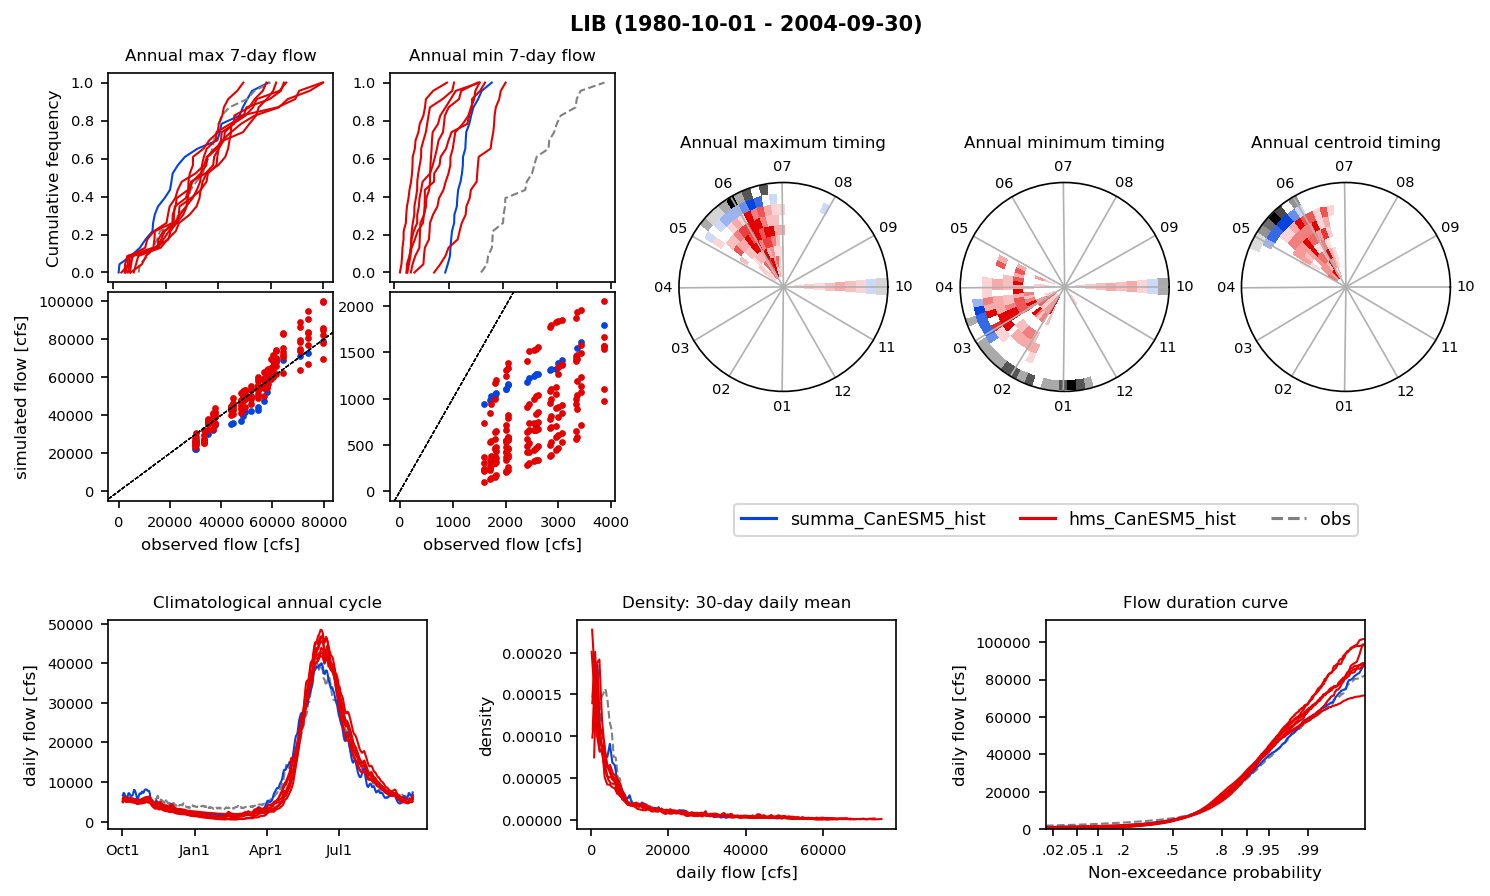

In [17]:
%matplotlib auto

# number of bins in r and theta dimensions
N_bins_theta = 73 #365/5 divide 365 days into 73 5day-periods
rmax = 10         # radial axis maximum (this is arbitary)
rmin = 0          # radial axis minimum (this is arbitary)

mpl.rcParams['xtick.labelsize'] = 7 
mpl.rcParams['ytick.labelsize'] = 7 
mpl.rcParams['axes.labelsize'] = 8 
mpl.rcParams['axes.titlesize'] = 8 

date_tick_loc = np.searchsorted(pd.date_range(start='10/1/2000', end='9/30/2001'), 
                ['2000-10-01', '2001-01-01', '2001-04-01', '2001-07-01'])

polar_date_tick_loc = np.searchsorted(pd.date_range(start='10/1/2000', end='9/30/2001'), 
                ['2000-10-01','2000-11-01','2000-12-01','2001-01-01','2001-02-01','2001-03-01','2001-04-01','2001-05-01','2001-06-01','2001-07-01','2001-08-01','2001-09-01'])


cmap_obs = LinearSegmentedColormap.from_list('custom3', 
                                             [(0.0, 'xkcd:white'),
                                              (1.0, 'xkcd:black')], N=256)

for site in plot_sites:
    
    fig = plt.figure(figsize=(10.0, 6.0), dpi=150)
    gs = mpl.gridspec.GridSpec(7,15)
    gs.update(top=0.915, bottom=0.075, left=0.075, right=0.975, wspace=1.50, hspace=0.10)

    ax1 =  fig.add_subplot(gs[0:2, 0:3])
    ax2 =  fig.add_subplot(gs[0:2, 3:6])
    
    ax6 =  fig.add_subplot(gs[2:4, 0:3])
    ax7 =  fig.add_subplot(gs[2:4, 3:6])
    
    ax8 =  fig.add_subplot(gs[1:3, 6:9],   projection='polar')
    ax9 =  fig.add_subplot(gs[1:3, 9:12],  projection='polar')
    ax10 = fig.add_subplot(gs[1:3, 12:15], projection='polar')
    
    ax11 = fig.add_subplot(gs[5:7:, 0:4])
    ax12 = fig.add_subplot(gs[5:7:, 5:9])
    ax13 = fig.add_subplot(gs[5:7:, 10:14])

    for ix, case in enumerate(ds_sim.keys()):
        if case.split('_')[0]=='summa':
            case1=case
        elif case.split('_')[0]=='hms':
            case1=case.rsplit('_',1)[0]
        cmap = LinearSegmentedColormap.from_list('custom1', 
                                            [(0.0, 'xkcd:white'), (1.0, sim_cases[case1]['c'])], N=256)
        # 1. maximum flow cdf
        obs_sorted = np.sort(ds_annual_max_obs['ann_max_flow'].sel(site=site).values)
        sim_sorted = np.sort(ds_annual_max[case]['ann_max_flow'].sel(site=site).values)
        prob = 1. * np.arange(len(obs_sorted)) / (len(obs_sorted) - 1)
        ax1.plot(sim_sorted, prob, lw=1.0, c=sim_cases[case1]['c'])
        if ix==0:
            ax1.plot(obs_sorted, prob, linewidth=1.0, c='grey',ls='--')
            
        # 2. maximum flow scatter
        ax6.scatter(obs_sorted, sim_sorted, s=5, c=sim_cases[case1]['c'])
        ax6.axline((1, 1), slope=1, c='k', lw=0.5, ls='--')

        # 3. minimum flow cdf
        obs_sorted = np.sort(ds_annual_min_obs['ann_min_flow'].sel(site=site).values)
        sim_sorted = np.sort(ds_annual_min[case]['ann_min_flow'].sel(site=site).values)
        ax2.plot(sim_sorted, prob, linewidth=1.0, c=sim_cases[case1]['c'])
        if ix==0:
            ax2.plot(obs_sorted, prob, linewidth=1.0, c='grey',ls='--')

        # 4. minimum flow scatter
        ax7.scatter(obs_sorted, sim_sorted, s=5, c=sim_cases[case1]['c'])
        ax7.axline((1, 1), slope=1, c='k', lw=0.5, ls='--')

        # 5. maximum flow timing
        if ix==0:
            obs_time = ds_annual_max_obs['ann_max_day'].sel(site=site).values
            freq, bin = np.histogram(obs_time, range=(0,365), bins=73)
            freq = np.reshape(freq/len(obs_time), (1, len(freq)))
            r     = [rmax-1,rmax]
            theta = 2*np.pi*bin/365.0
            ax8.pcolormesh(theta, r, freq, cmap=cmap_obs)        
        sim_time = ds_annual_max[case]['ann_max_day'].sel(site=site).values
        freq, bin = np.histogram(sim_time, range=(0, 365), bins=N_bins_theta)
        freq = np.reshape(freq/len(sim_time), (1, len(freq)))
        r     = [rmax-ix-2, rmax-ix-1]
        theta = 2*np.pi*bin/365.0
        ax8.pcolormesh(theta, r, freq, cmap=cmap)

        # 6. minimum flow timing    
        if ix==0:
            obs_time = ds_annual_min_obs['ann_min_day'].sel(site=site).values
            freq, bin = np.histogram(obs_time, range=(0,365), bins=73)
            freq = np.reshape(freq/len(obs_time), (1, len(freq)))
            r     = [rmax-1,rmax]
            theta = 2*np.pi*bin/365.0
            ax9.pcolormesh(theta, r, freq, cmap=cmap_obs)        
        sim_time = ds_annual_min[case]['ann_min_day'].sel(site=site).values
        freq, bin = np.histogram(sim_time, range=(0, 365), bins=N_bins_theta)
        freq = np.reshape(freq/len(sim_time), (1, len(freq)))
        r     = [rmax-ix-2, rmax-ix-1]
        theta = 2*np.pi*bin/365.0
        ax9.pcolormesh(theta, r, freq, cmap=cmap)

        # 7. centroid
        if ix==0:
            obs_time = ds_annual_centroid_obs['ann_centroid_day'].sel(site=site).values
            freq, bin = np.histogram(obs_time, range=(0,365), bins=73)
            freq = np.reshape(freq/len(sim_time), (1, len(freq)))
            r     = [rmax-1,rmax]
            theta = 2*np.pi*bin/365.0
            ax10.pcolormesh(theta, r, freq, cmap=cmap_obs)        
        sim_time = ds_annual_centroid[case]['ann_centroid_day'].sel(site=site).values
        freq, bin = np.histogram(sim_time, range=(0, 365), bins=N_bins_theta)
        freq = np.reshape(freq/len(sim_time), (1, len(freq)))
        r     = [rmax-ix-2, rmax-ix-1]
        theta = 2*np.pi*bin/365.0
        ax10.pcolormesh(theta, r, freq, cmap=cmap)
        
        # 8. daily step seasonal cycle
        if ix==0:
            ds_tmp = ds_obs.sel(site=site)['streamflow'].sel(time=analysis_period)
            ds_tmp = ds_tmp.assign_coords(time=ds_tmp['time'] - pd.Timedelta(days=273))
            ds_tmp.groupby('time.dayofyear').mean('time').plot(ax=ax11, ls='--', lw=1.0, c='grey')
        ds_tmp = ds_sim[case].sel(site=site)['streamflow'].sel(time=analysis_period)
        ds_tmp = ds_tmp.assign_coords(time=ds_tmp['time'] - pd.Timedelta(days=273))
        ds_tmp.groupby('time.dayofyear').mean('time').plot(ax=ax11, lw=1.0, c=sim_cases[case1]['c'])

        # 9. Flow density
        if ix==0:
            obs_array = ds_obs.sel(site=site)['streamflow'].rolling(time=30, center=True).mean().sel(time=analysis_period)
            y, x = np.histogram(obs_array, bins=np.linspace(obs_array.min(), obs_array.max(), 100),density=True)
            ax12.plot(x[:-1], y, ls='--', lw=1.0, c='grey')
        sim_flow = ds_sim[case].sel(site=site)['streamflow'].rolling(time=30, center=True).mean().sel(time=analysis_period)
        y, x = np.histogram(sim_flow, bins=np.linspace(sim_flow.min(), sim_flow.max(), 100), density=True)
        ax12.plot(x[:-1], y, lw=1.0, c=sim_cases[case1]['c'])
    
        # 10. flow duration curve
        if ix==0:
            obs_array = ds_obs.sel(site=site)['streamflow'].sel(time=analysis_period).values
            obs_prob=np.arange(1,float(len(obs_array))+1)/(1+len(obs_array))  #probability 
            obs_flow_sort =  obs_array[np.argsort(obs_array)]
            ax13.plot(obs_prob, obs_flow_sort, ls='--', lw=1.0, c='grey')
            imax = np.where(obs_prob<0.9995)
            maxflow = max(obs_flow_sort[imax])
            minflow = min(obs_flow_sort[imax])
        sim_flow = ds_sim[case].sel(site=site)['streamflow'].sel(time=analysis_period).values
        sim_flow_sort =  sim_flow[np.argsort(sim_flow)]          
        sim_prob = np.arange(1,float(len(sim_flow)+1))/(1+len(sim_flow)) #probability 
        imax = np.where(sim_prob<0.9995)
        maxflow = max(maxflow, max(sim_flow_sort[imax])) 
        minflow = min(minflow, min(sim_flow_sort[imax])) 
        ax13.plot(sim_prob, sim_flow_sort, ls='-', lw=1.0, c=sim_cases[case1]['c'])
    
    # axis annotations
    ax1.set_title('Annual max 7-day flow')
    ax1.set_xlabel('')
    ax1.set_ylabel('Cumulative fequency')
    ax1.set_xticklabels('')
    
    ax2.set_title('Annual min 7-day flow')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_xticklabels('')
    
    ax6.set_xlabel(f'observed flow [{flow_unit}]')
    ax6.set_ylabel(f'simulated flow [{flow_unit}]')
    
    ax7.set_xlabel(f'observed flow [{flow_unit}]')
    ax7.set_ylabel('')
    
    ax8.set_title('Annual maximum timing')
    ax8.set_rmax(rmax*1.01)
    ax8.yaxis.grid(False)
    ax8.set_yticklabels([])
    ax8.set_theta_direction(-1)
    ax8.set_xticks(2*np.pi*polar_date_tick_loc/365.0)
    ax8.set_xticklabels(['10','11','12','01','02','03','04','05','06','07','08','09'])
    ax8.tick_params(pad=-3)
        
    ax9.set_title('Annual minimum timing')
    ax9.set_rmax(rmax*1.01)
    ax9.yaxis.grid(False)
    ax9.set_yticklabels([])
    ax9.set_theta_direction(-1)
    ax9.set_xticks(2*np.pi*polar_date_tick_loc/365.0)
    ax9.set_xticklabels(['10','11','12','01','02','03','04','05','06','07','08','09'])
    ax9.tick_params(pad=-3)
    
    ax10.set_title('Annual centroid timing')
    ax10.set_rmax(rmax*1.01)
    ax10.yaxis.grid(False)
    ax10.set_yticklabels([])
    ax10.set_theta_direction(-1)
    ax10.set_xticks(2*np.pi*polar_date_tick_loc/365.0)
    ax10.set_xticklabels(['10','11','12','01','02','03','04','05','06','07','08','09'])
    ax10.tick_params(pad=-3)
    
    ax11.set_title('Climatological annual cycle')
    ax11.set_xticks(date_tick_loc)
    ax11.set_xticklabels(['Oct1','Jan1','Apr1','Jul1'])
    ax11.set_xlabel('')
    ax11.set_ylabel(f'daily flow [{flow_unit}]')
    
    ax12.set_title('Density: 30-day daily mean')
    ax12.set_xlabel(f'daily flow [{flow_unit}]')
    ax12.set_ylabel('density')
    
    ax13.set_title('Flow duration curve')
    ax13.set_xlabel('Non-exceedance probability')
    ax13.set_ylabel(f'daily flow [{flow_unit}]')
    #ax13.set_yscale('log')
    ax13.set_xscale('ppf')
    ax13.set_xlim([0.015, 0.9995])
    ax13.set_ylim([-10, maxflow*1.10])

    # access legend objects automatically created from data
    handles, labels = plt.gca().get_legend_handles_labels()

    # create manual symbols for legend
    line4legend = []
    #for ix, case in enumerate(ds_sim.keys()): 
    for ix, case in enumerate(sim_cases.keys()):
        line4legend.append(Line2D([0], [0], label=case, color=sim_cases[case]['c']))
    line4legend.append(Line2D([0], [0], ls='--', label='obs', color='grey'))
    # add manual symbols to auto legend
    handles.extend(line4legend)
    if len(ax13.lines)>4:
        ncol=4
    else:
        ncol=len(ax13.lines)
    ax13.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.0, 1.60), ncol=ncol, fontsize='small')
    
    fig.suptitle('%s (%s - %s)'%(site, start_date, end_date), fontsize='medium', fontweight="bold");
    plotFname=os.path.join('./figures/','fig1_flow_summary_%s_%s-%s.png'%(site, start_date[0:4], end_date[0:4]))
    plt.savefig(plotFname, dpi=200)

### 5.2. Flow duration curves

In [15]:
list(ds_sim.keys())

['summa_CanESM5_hist',
 'hms_CanESM5_hist_M1',
 'hms_CanESM5_hist_M2',
 'hms_CanESM5_hist_M3',
 'hms_CanESM5_hist_M4',
 'hms_CanESM5_hist_M5',
 'hms_CanESM5_hist_M6',
 'hms_CanESM5_hist_M7',
 'hms_CanESM5_ssp370_M1',
 'hms_CanESM5_ssp370_M2',
 'hms_CanESM5_ssp370_M3',
 'hms_CanESM5_ssp370_M4',
 'hms_CanESM5_ssp370_M5',
 'hms_CanESM5_ssp370_M6',
 'hms_CanESM5_ssp370_M7',
 'summa_CanESM5_ssp370']

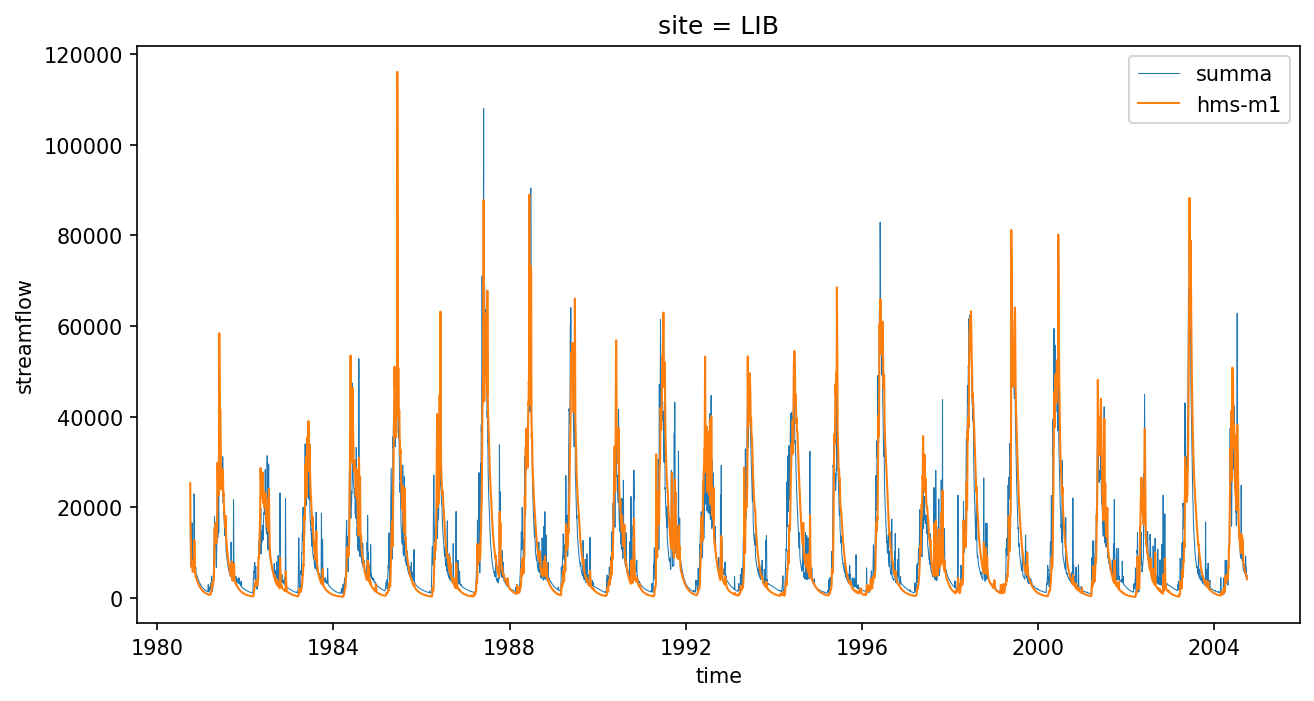

In [83]:
fig = plt.figure(figsize=(10.0, 5.0), dpi=150)
time_period=slice('1980-10-01','2004-09-30')
ds_sim['summa_CanESM5_hist']['streamflow'].sel(time=time_period).plot(lw=0.5, label='summa')
ds_sim['hms_CanESM5_hist_M1']['streamflow'].sel(time=time_period).plot(lw=1, label='hms-m1')
plt.legend()

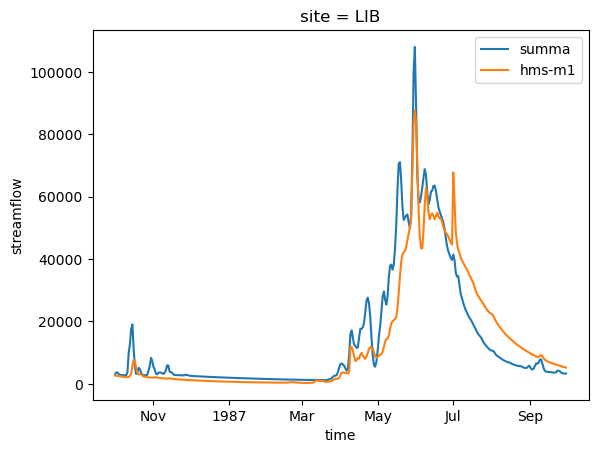

In [81]:
time_period=slice('1986-10-01','1987-09-30')
ds_sim['summa_CanESM5_hist']['streamflow'].sel(time=time_period).plot(label='summa')
ds_sim['hms_CanESM5_hist_M1']['streamflow'].sel(time=time_period).plot(label='hms-m1')
plt.legend()

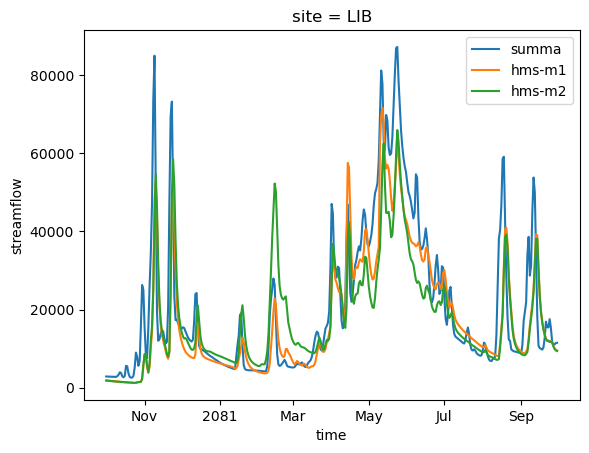

In [73]:
time_period=slice('2080-10-01','2081-09-30')
ds_sim['summa_CanESM5_ssp370']['streamflow'].sel(time=time_period).plot(label='summa')
ds_sim['hms_CanESM5_ssp370_M1']['streamflow'].sel(time=time_period).plot(label='hms-m1')
ds_sim['hms_CanESM5_ssp370_M2']['streamflow'].sel(time=time_period).plot(label='hms-m2')
plt.legend()

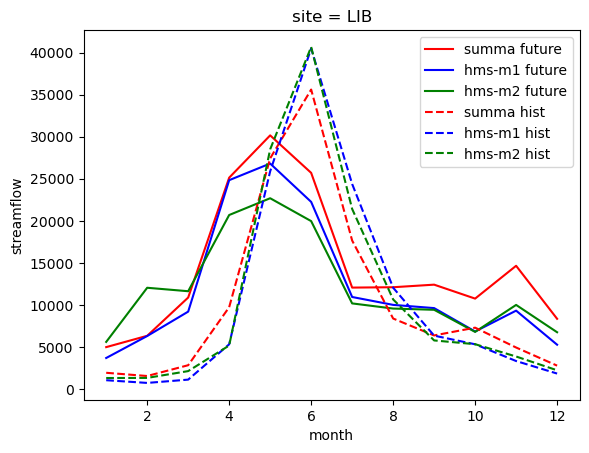

In [69]:
time_period=slice('2080-10-01','2099-09-30')
ds_sim['summa_CanESM5_ssp370']['streamflow'].sel(time=time_period).groupby('time.month').mean().plot(c='r',label='summa future')
ds_sim['hms_CanESM5_ssp370_M1']['streamflow'].sel(time=time_period).groupby('time.month').mean().plot(c='b',label='hms-m1 future')
ds_sim['hms_CanESM5_ssp370_M2']['streamflow'].sel(time=time_period).groupby('time.month').mean().plot(c='g',label='hms-m2 future')

time_period=slice('1980-10-01','2004-09-30')
ds_sim['summa_CanESM5_hist']['streamflow'].sel(time=time_period).groupby('time.month').mean().plot(c='r', ls='--',label='summa hist')
ds_sim['hms_CanESM5_hist_M1']['streamflow'].sel(time=time_period).groupby('time.month').mean().plot(c='b',ls='--',label='hms-m1 hist')
ds_sim['hms_CanESM5_hist_M2']['streamflow'].sel(time=time_period).groupby('time.month').mean().plot(c='g',ls='--',label='hms-m2 hist')
plt.legend();

In [96]:
hms_fut_sort.shape

(6575,)

In [98]:
summa_fut_sort.shape

(6939,)

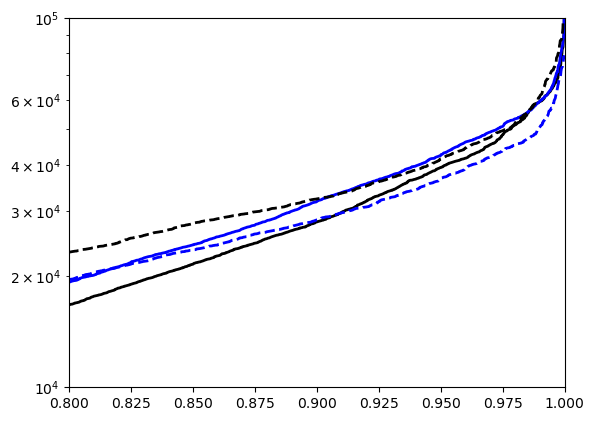

In [104]:
time_period_hist=slice('1980-10-01','2004-09-30')
summa_hist = ds_sim['summa_CanESM5_hist']['streamflow'].sel(time=time_period_hist).values.squeeze()
hms_hist = ds_sim['hms_CanESM5_hist_M1']['streamflow'].sel(time=time_period_hist).values.squeeze()

time_period_future = slice('2080-10-01','2098-09-30')
summa_fut = ds_sim['summa_CanESM5_ssp370']['streamflow'].sel(time=time_period_future).values.squeeze()
hms_fut = ds_sim['hms_CanESM5_ssp370_M1']['streamflow'].sel(time=time_period_future).values.squeeze()

hist_prob=np.arange(1,float(len(summa_hist)+1))/(1+len(summa_hist))  #probability 
fut_prob=np.arange(1,float(len(summa_fut)+1))/(1+len(summa_fut))  #probability 

summa_hist_sort =  summa_hist[np.argsort(summa_hist)]
hms_hist_sort =  hms_hist[np.argsort(hms_hist)]
plt.plot(hist_prob, summa_hist_sort, ls='-', lw=2.0, color='black', label='summa')
plt.plot(hist_prob, hms_hist_sort, ls='-', lw=2.0, color='blue', label='hms')

summa_fut_sort =  summa_fut[np.argsort(summa_fut)]
hms_fut_sort =  hms_fut[np.argsort(hms_fut)]
plt.plot(fut_prob, summa_fut_sort, ls='--', lw=2.0, color='black', label='summa')
plt.plot(fut_prob, hms_fut_sort, ls='--', lw=2.0, color='blue', label='hms')
plt.xlim([0.8,1.0])
plt.ylim([10000,100000])
plt.yscale('log')